# Pattern1 isoline demo (from Hugging Face dataset)

This notebook is a **clean example** of how to run *pattern1 isoline* generation by importing functions from the `histoseg` package.

Data source (Hugging Face dataset repo):
- `cells.parquet`
- `tissue_boundary.csv`
- `analysis/clustering/gene_expression_graphclust/clusters.csv`

In [1]:
# Install:
# %pip install histoseg

# If you are using Hugging Face dataset:
# %pip install -U huggingface_hub pandas pyarrow numpy scipy scikit-learn seaborn matplotlib

In [2]:
from histoseg.io.huggingface import download_xenium_outs

repo_id = "hutaobo/output-XETG00082_C105"
revision = "main"  # or a commit hash for full reproducibility

paths = download_xenium_outs(repo_id, revision=revision)
paths

/home/taobo.hu/miniconda3/envs/pyXenium/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


XeniumOutsPaths(repo_id='hutaobo/output-XETG00082_C105', revision='main', cells_parquet=PosixPath('/home/taobo.hu/.cache/huggingface/hub/datasets--hutaobo--output-XETG00082_C105/snapshots/b631d7ebd0670b5328600847101c83b32bf060d0/cells.parquet'), tissue_boundary_csv=PosixPath('/home/taobo.hu/.cache/huggingface/hub/datasets--hutaobo--output-XETG00082_C105/snapshots/b631d7ebd0670b5328600847101c83b32bf060d0/tissue_boundary.csv'), clusters_csv=PosixPath('/home/taobo.hu/.cache/huggingface/hub/datasets--hutaobo--output-XETG00082_C105/snapshots/b631d7ebd0670b5328600847101c83b32bf060d0/analysis/clustering/gene_expression_graphclust/clusters.csv'))

[OK] merged cells: 76,708 | id_col_used='cell_id' | x_col='x_centroid' | y_col='y_centroid'
[OK] n_clusters: 27


,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,27
cluster,,,,,,,,,,,,,,,,,,,,,
1,0.000000,189.481109,26.796084,95.783750,27.670937,84.298795,26.533475,45.022125,38.236608,47.300436,...,67.494201,117.968572,157.519318,91.151025,100.698155,105.076904,210.404466,211.465230,200.437035,148.674531
2,163.304392,0.000000,23.937344,44.288436,28.938113,82.422776,182.953147,35.494171,34.435675,241.936154,...,65.411109,315.322287,298.944846,89.822080,99.160780,301.989132,66.157781,417.371846,377.627263,353.477557
3,66.917652,111.915995,0.000000,58.054787,28.385738,61.756646,81.571386,40.044780,36.277175,124.278719,...,63.415542,199.032824,220.216427,86.716556,94.303853,187.461808,142.185665,295.269370,275.099666,231.551400
4,86.528489,54.586087,24.543284,0.000000,30.117932,27.961987,108.997498,36.369638,34.036210,169.225567,...,58.741441,243.348531,259.344052,78.507564,80.962679,231.925555,90.454525,355.257536,334.046981,279.943622
5,55.276290,133.740196,25.871216,72.468004,0.000000,72.490414,68.868264,39.715704,37.035758,102.493996,...,63.672230,169.824345,191.899338,87.718214,98.196741,159.494191,162.566706,262.954485,247.691873,201.569064


Row cophenetic correlation coefficient: 0.8360
Column cophenetic correlation coefficient: 0.8474


/home/taobo.hu/miniconda3/envs/pyXenium/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/taobo.hu/miniconda3/envs/pyXenium/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


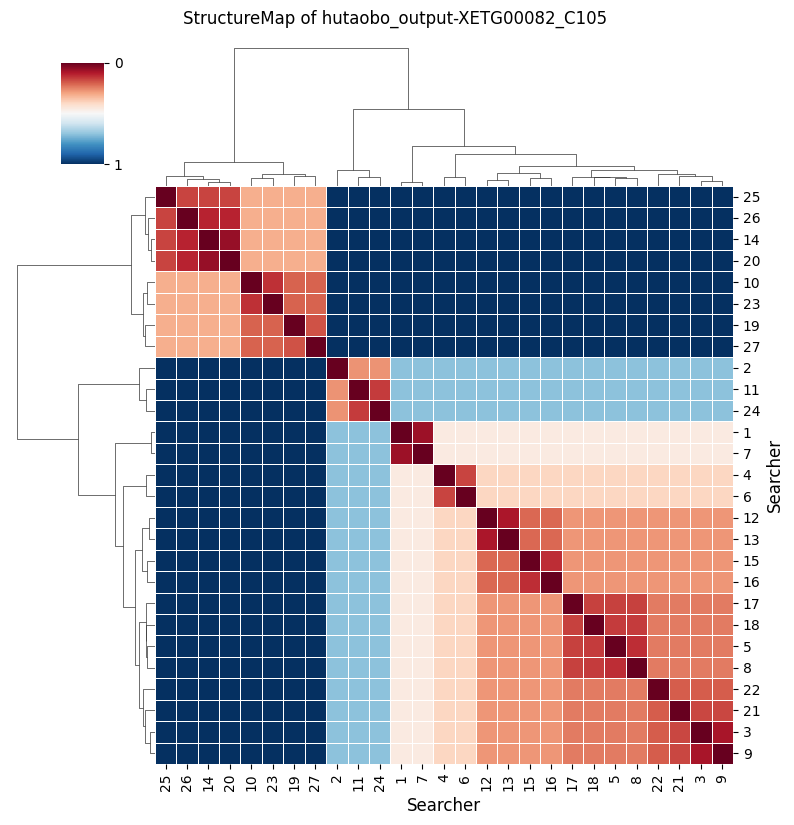

In [3]:
# === Infer PATTERN1 from SFplot StructureMap (Searcher→Findee distances) ===
import numpy as np
import pandas as pd
from IPython.display import display

# 1) Import the two requested functions (plus the minimal helper needed to obtain cophenetic matrices)
from histoseg.sfplot.Searcher_Findee_Score import (
    compute_searcher_findee_distance_matrix_from_df,
    compute_cophenetic_from_distance_matrix,   # in the same file; required to generate "cophenetic" matrices
    plot_cophenetic_heatmap,
)

# 2) Build the per-cell dataframe required by compute_searcher_findee_distance_matrix_from_df
#    Reuse the repo's alignment logic (Barcode ↔ cells.parquet id-like column + x/y inference).
from histoseg.contours.pattern1_isoline import align_clusters_with_cells

merged, id_col_used, x_col, y_col = align_clusters_with_cells(paths.clusters_csv, paths.cells_parquet)

merged = merged.copy()
merged["cluster"] = pd.to_numeric(merged["cluster"], errors="coerce").astype("Int64")
merged = merged.dropna(subset=["cluster"]).copy()
merged["cluster"] = merged["cluster"].astype(int)

print(f"[OK] merged cells: {len(merged):,} | id_col_used='{id_col_used}' | x_col='{x_col}' | y_col='{y_col}'")
print(f"[OK] n_clusters: {merged['cluster'].nunique()}")

# Optional speed knob for very large datasets (None = use all)
MAX_CELLS = None  # e.g. 100_000
if MAX_CELLS is not None and len(merged) > MAX_CELLS:
    merged = merged.sample(n=MAX_CELLS, random_state=0).copy()
    print(f"[INFO] downsampled to {len(merged):,} cells for speed")

# 3) Compute directed mean 1-NN distance matrix: (searcher cluster) -> (findee cluster)
distance_matrix = compute_searcher_findee_distance_matrix_from_df(
    merged,
    x_col=x_col,
    y_col=y_col,
    z_col=None,
    celltype_col="cluster",
)
display(distance_matrix.head())

# 4) Convert to cophenetic distance matrices (normalized to [0, 1] inside the function)
row_coph, col_coph = compute_cophenetic_from_distance_matrix(
    distance_matrix,
    method="average",
    show_corr=True,   # prints cophenetic correlation coefficients (row/col) for sanity check
)

# 5) Plot cophenetic heatmaps (return_figure=True to show inline, and to access dendrogram order)
g_row = plot_cophenetic_heatmap(
    row_coph,
    matrix_name="row_coph",
    sample=repo_id.replace("/", "_"),
    return_figure=True,
)

In [4]:
# === Infer PATTERN1 from the StructureMap's clustered row order (Optional) ===
# Heuristic: choose a contiguous block of size K with minimal mean intra-block cophenetic distance.
K = 8  # the tutorial example uses 8 clusters; adjust if you want a different pattern size

ordered_labels = [row_coph.index[i] for i in g_row.dendrogram_row.reordered_ind]
row_coph_ord = row_coph.loc[ordered_labels, ordered_labels]

def _mean_intrablock_distance(block_labels):
    sub = row_coph_ord.loc[block_labels, block_labels].to_numpy()
    iu = np.triu_indices_from(sub, k=1)
    return float(sub[iu].mean()) if len(iu[0]) else 0.0

best_block = None
best_score = np.inf
for start in range(0, len(ordered_labels) - K + 1):
    block = ordered_labels[start : start + K]
    score = _mean_intrablock_distance(block)
    if score < best_score:
        best_score = score
        best_block = block

# Convert labels to int if possible (GraphClust clusters are ints). Fall back to raw labels.
try:
    PATTERN1 = sorted(pd.to_numeric(pd.Index(best_block)).astype(int).tolist())
except Exception:
    PATTERN1 = list(best_block)

print(f"[RESULT] Inferred PATTERN1 (K={K}, mean_intra_distance={best_score:.4f}):")
print(PATTERN1)

# Optional: show the selected submatrix for quick inspection
display(row_coph.loc[best_block, best_block])

[RESULT] Inferred PATTERN1 (K=8, mean_intra_distance=0.2061):
[3, 5, 8, 9, 17, 18, 21, 22]


cluster,17,18,5,8,22,21,3,9
cluster,,,,,,,,
17,0.000000,0.156663,0.156663,0.156663,0.241253,0.241253,0.241253,0.241253
18,0.156663,0.000000,0.151043,0.151043,0.241253,0.241253,0.241253,0.241253
5,0.156663,0.151043,0.000000,0.132229,0.241253,0.241253,0.241253,0.241253
8,0.156663,0.151043,0.132229,0.000000,0.241253,0.241253,0.241253,0.241253
22,0.241253,0.241253,0.241253,0.241253,0.000000,0.196601,0.196601,0.196601
21,0.241253,0.241253,0.241253,0.241253,0.196601,0.000000,0.164353,0.164353
3,0.241253,0.241253,0.241253,0.241253,0.196601,0.164353,0.000000,0.087769
9,0.241253,0.241253,0.241253,0.241253,0.196601,0.164353,0.087769,0.000000


In [5]:
from histoseg.contours.pattern1_isoline import Pattern1IsolineConfig, run_pattern1_isoline

# PATTERN1 is inferred in the previous cell (SFplot StructureMap).
# If you want to override manually, uncomment and edit:
# PATTERN1 = [10, 23, 19, 27, 14, 20, 25, 26]

cfg = Pattern1IsolineConfig(
    clusters_csv=paths.clusters_csv,
    cells_parquet=paths.cells_parquet,
    tissue_boundary_csv=paths.tissue_boundary_csv,
    out_dir="outputs/pattern1_isoline0p5_from_graphclust",
    pattern1_clusters=PATTERN1,
    grid_n=1200,
    knn_k=30,
    smooth_sigma=5,
    min_cells_inside=10,
    use_synth_bg=True,
    save_params_json=True,
)

result = run_pattern1_isoline(cfg)

## Outputs

The pipeline saves (by default):
- `params.json` (all parameters + inferred join columns)
- `pattern1_isoline_<level>_<i>.npy` (contour vertices)
- `pattern1_isoline_<level>.png` (quick preview)

Check `result.out_dir` for the exact location.